✅ Model loaded successfully.

📋 Predictions:
--------------------------------------------------
Filename                  | Predicted            | Confidence
--------------------------------------------------
1/1 [==============================] - 0s 164ms/step
000037.jpg                | Alia_Bhatt           |  66.52%


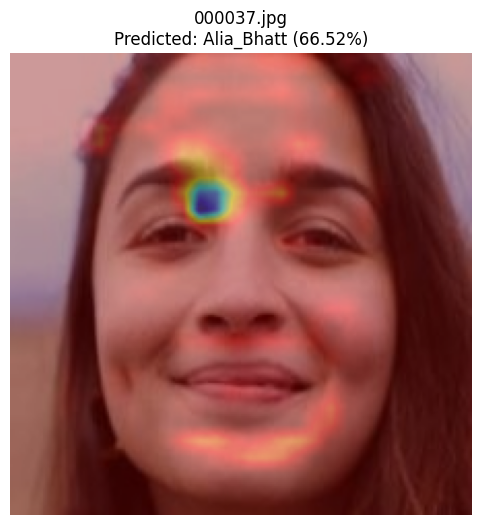

1/1 [==============================] - 0s 33ms/step
000038.jpg                | Amitabh_Bachchan     | 100.00%


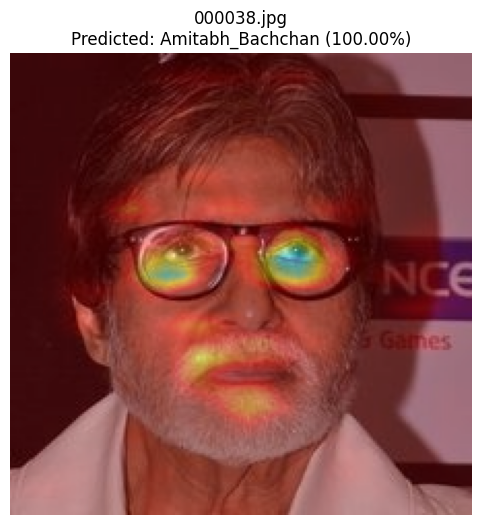

1/1 [==============================] - 0s 24ms/step
000040.png                | Aishwarya_Rai        | 100.00%


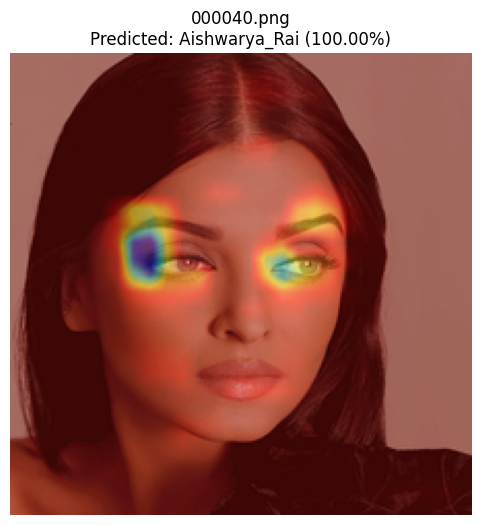

1/1 [==============================] - 0s 24ms/step
AG.jpg                    | Ariana_Grande        | 100.00%


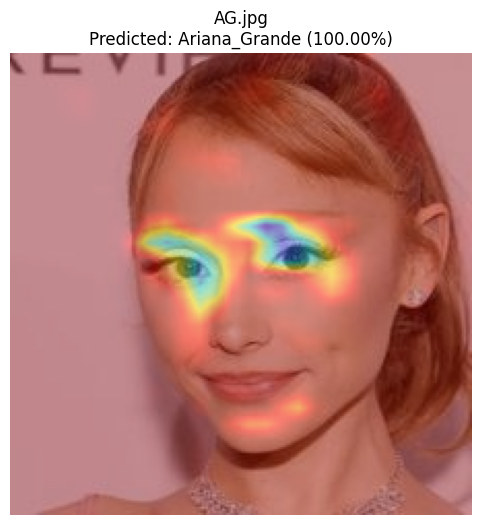

1/1 [==============================] - 0s 24ms/step
Aishwarya_Rai_000107.jpg  | Aishwarya_Rai        |  99.66%


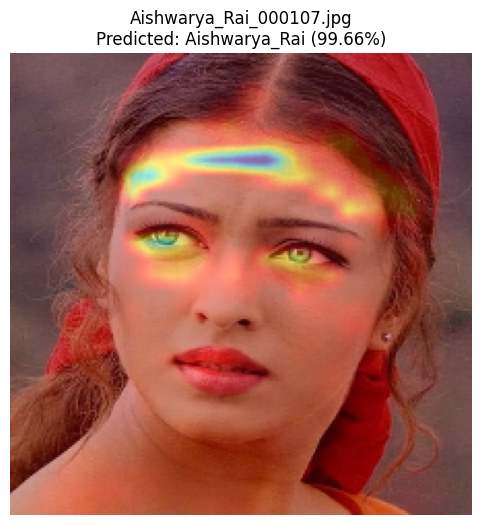

1/1 [==============================] - 0s 23ms/step
aki.jpeg                  | Akshay_Kumar         | 100.00%


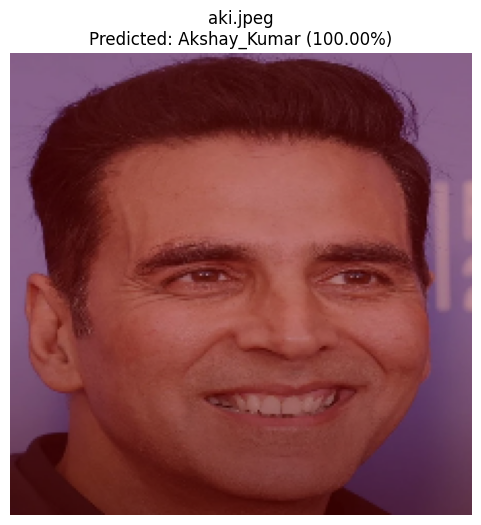

1/1 [==============================] - 0s 19ms/step
akki.jpeg                 | Akshay_Kumar         |  75.08%


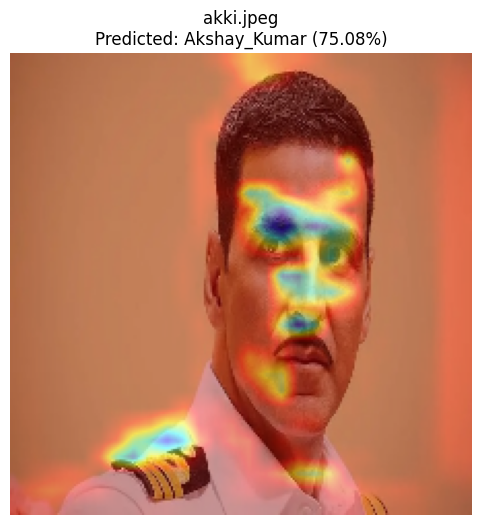

1/1 [==============================] - 0s 20ms/step
Akshay_Kumar_Portrait of Indian film actor Akshay Kumar..jpg | Akshay_Kumar         |  91.44%


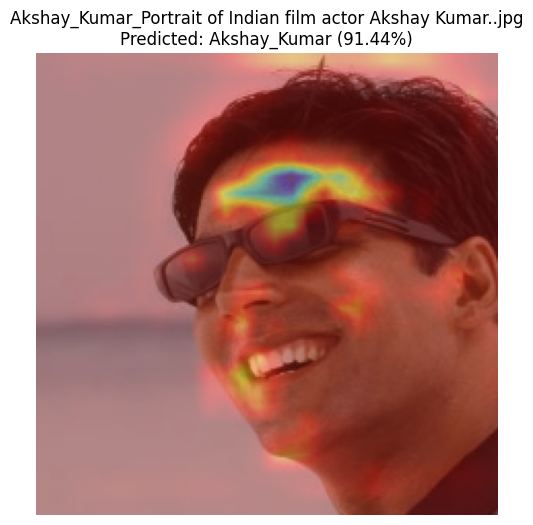

1/1 [==============================] - 0s 25ms/step
Alia_Bhatt_Image was converted to black and white) Alia Bhatt attends the 'Gully Boy' Photocall at the 69th Berlinale International Film Festival Berlin on....jpg | Alia_Bhatt           |  89.74%


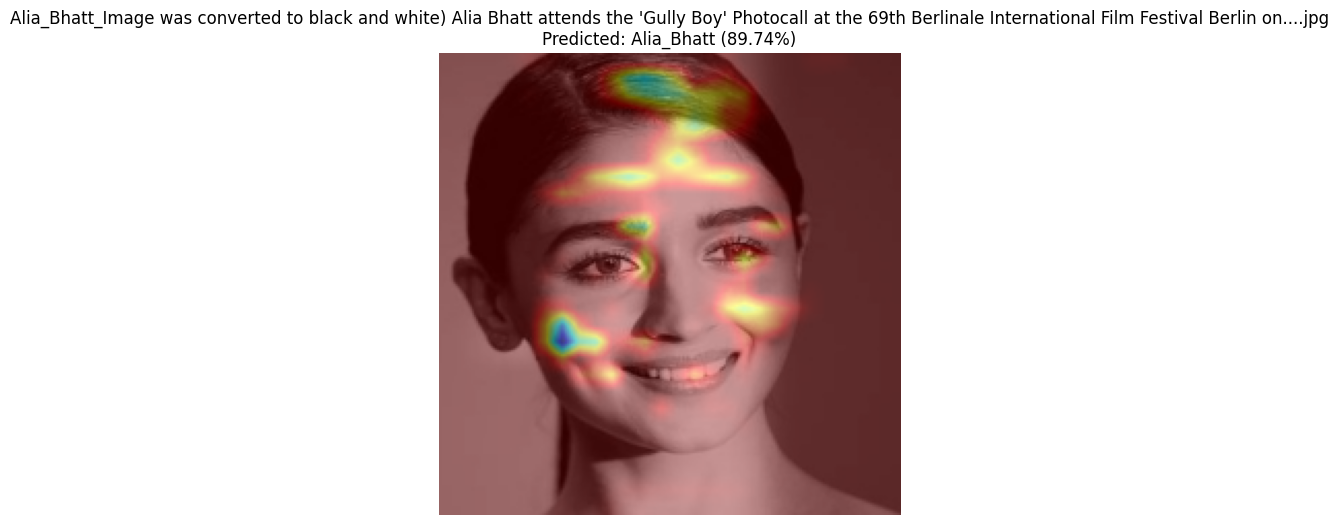

1/1 [==============================] - 0s 19ms/step
Allu_Arjun_Allu Arjun, stylish star, stylish star allu arjun, HD phone wallpaper_2.jpg | Allu_Arjun           | 100.00%


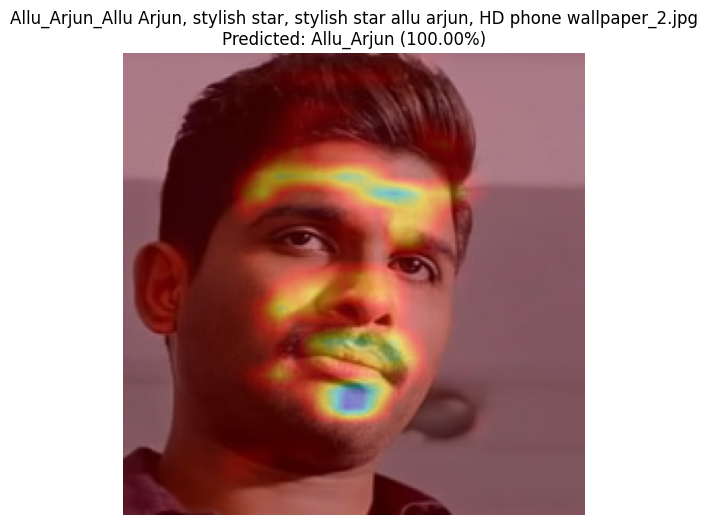

1/1 [==============================] - 0s 20ms/step
Amitabh_Bachchan_Indian film star Amitabh Bachchan at the House of Commons for the official announcement that the 2007 International Indian Film Academy Weekend will....jpg | Shah_Rukh_Khan       |  49.34%


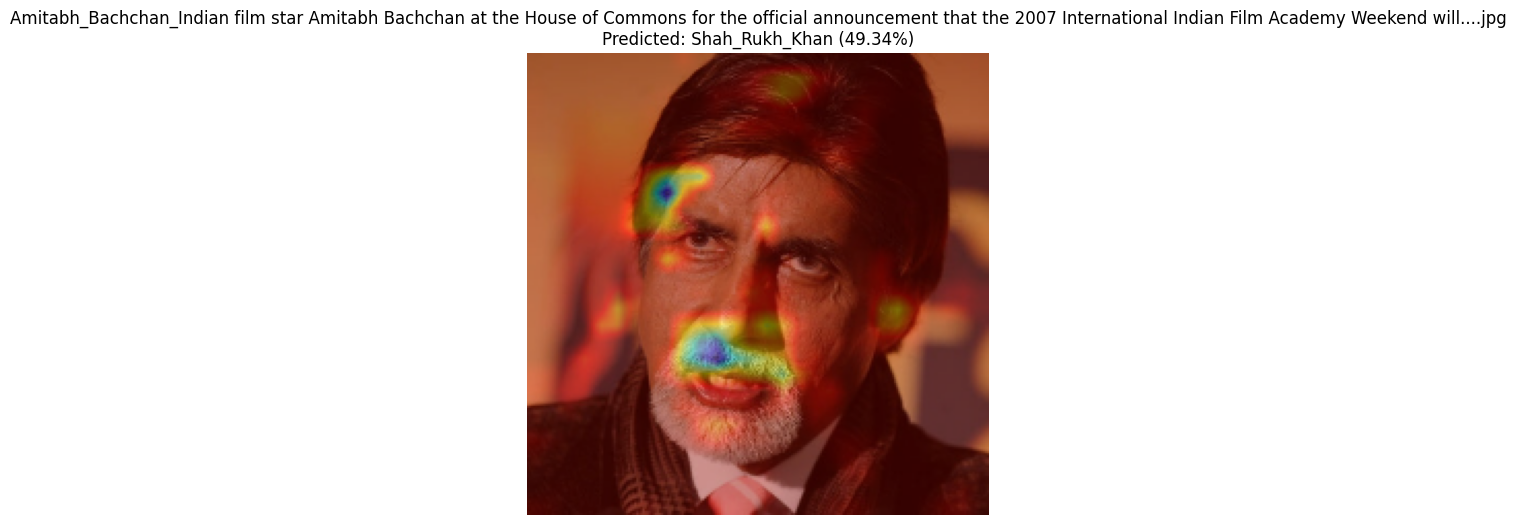

1/1 [==============================] - 0s 23ms/step
Angelina_Jolie_000108.jpg | Jennifer_Lawrence    |  75.50%


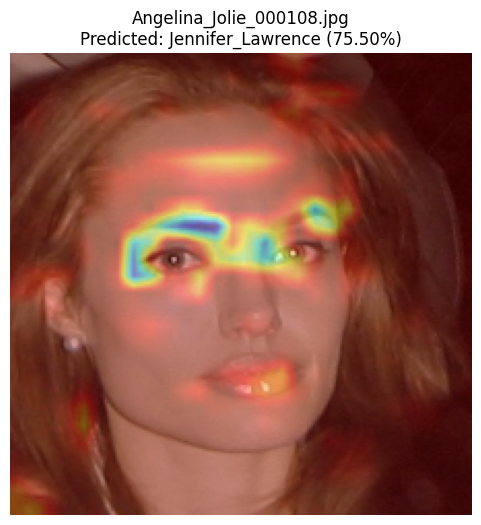

1/1 [==============================] - 0s 21ms/step
Ariana_Grande_Singer-songwriter Ariana Grande arrives for the 82nd annual Golden Globe Awards at the Beverly Hilton hotel in Beverly Hills, California, on January...-001.jpg | Ariana_Grande        |  86.36%


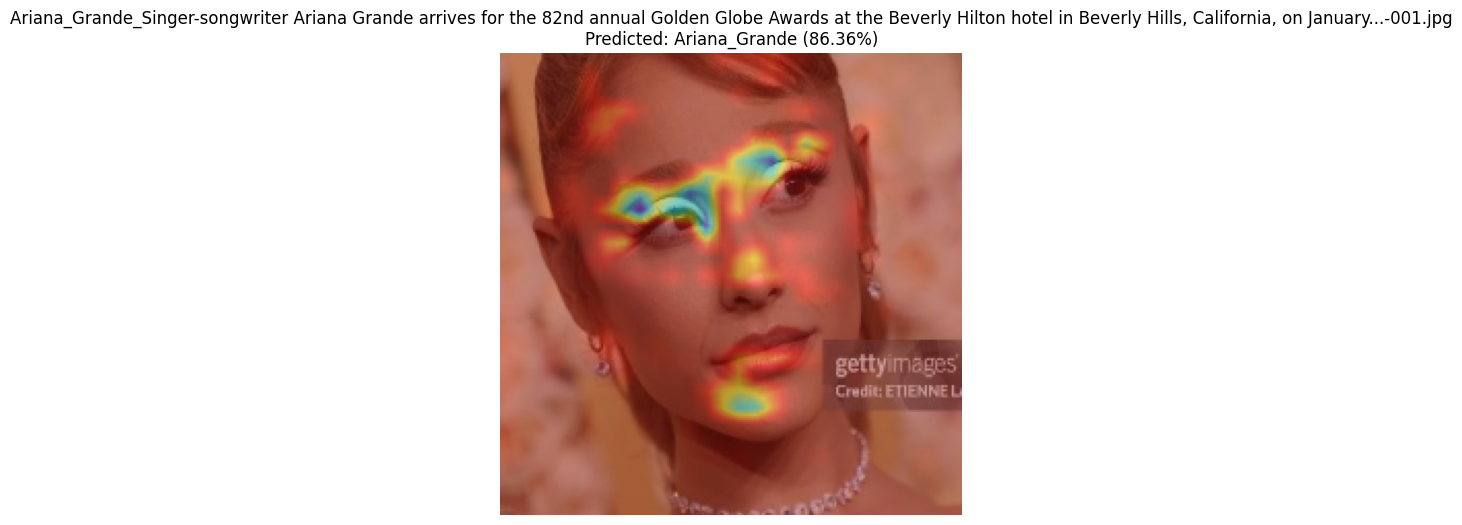

1/1 [==============================] - 0s 30ms/step
Barack_Obama_The 44th President of The United States Barak Obama, poses backstage at The Roundabout Theatre Company's production of _Arthur Miller's The Price_ on....jpg | Barack_Obama         | 100.00%


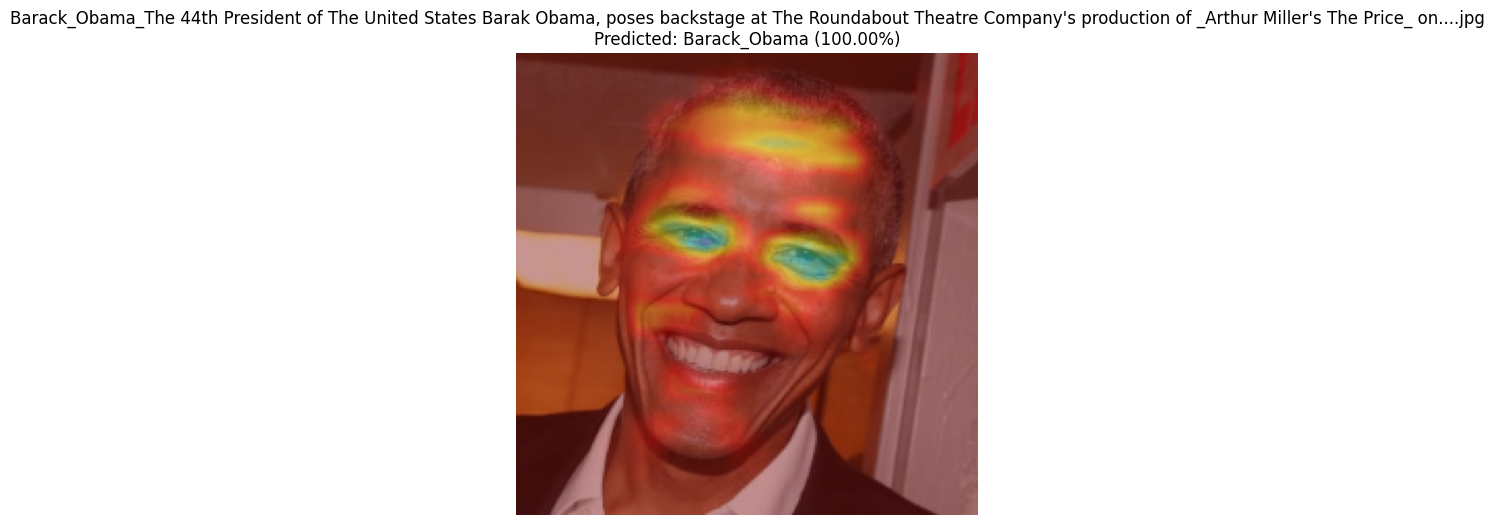

1/1 [==============================] - 0s 28ms/step
Billie_Eilish_000112.jpg  | Kareena_Kapoor       |  99.82%


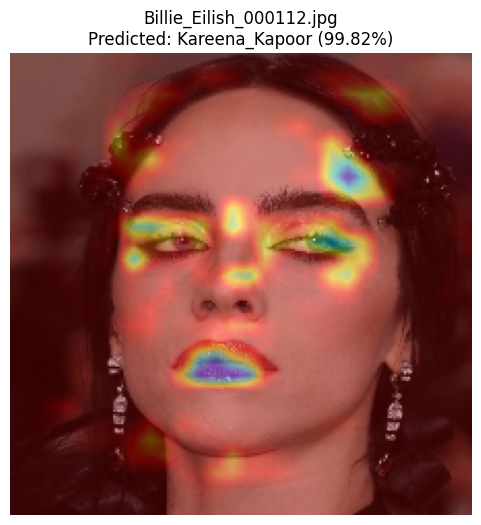

1/1 [==============================] - 0s 44ms/step
Bill_Gates_World Economic Forum -- Pictured_ Bill Gates, Microsoft Chairman, during an interview at the annual World Economic Forum in Davos, Switzerland, on....jpg | Bill_Gates           | 100.00%


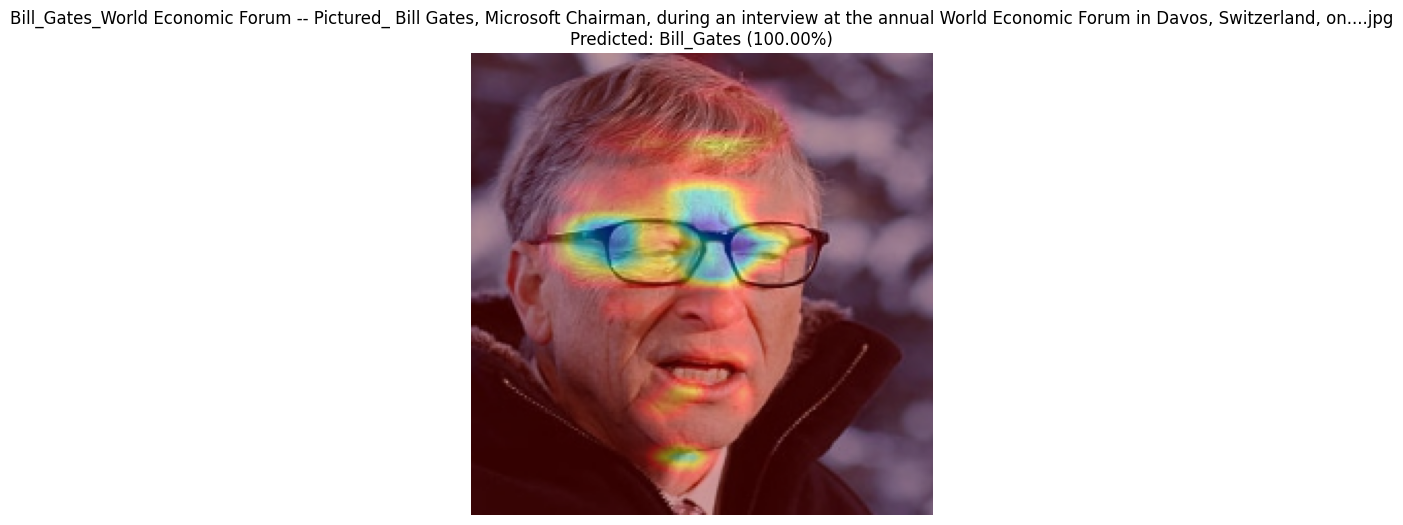

1/1 [==============================] - 0s 32ms/step
Brad_Pitt_000122.jpg      | Brad_Pitt            |  99.99%


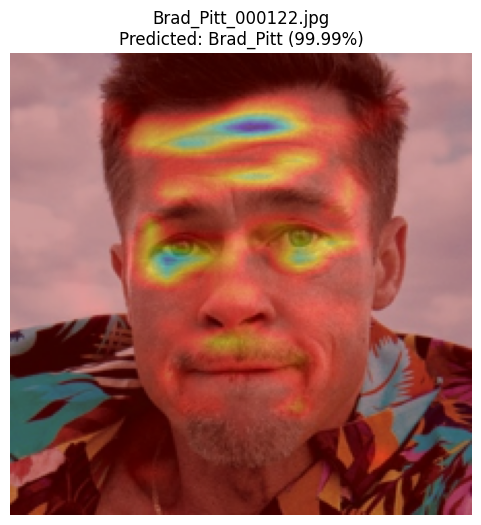

1/1 [==============================] - 0s 48ms/step
Chris_Evans_000108.jpg    | Chris_Evans          |  99.95%


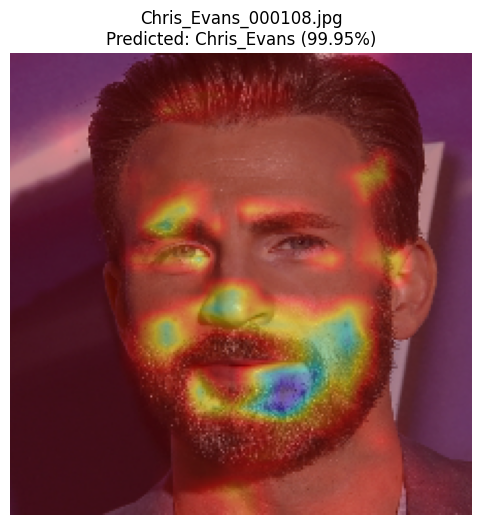

1/1 [==============================] - 0s 28ms/step
Cristiano_Ronaldo_Juventus' Portuguese forward Cristiano Ronaldo leaves the pitch at the end of the Italian Serie A football match Bologna vs Juventus on June 22, 2020....jpg | Cristiano_Ronaldo    | 100.00%


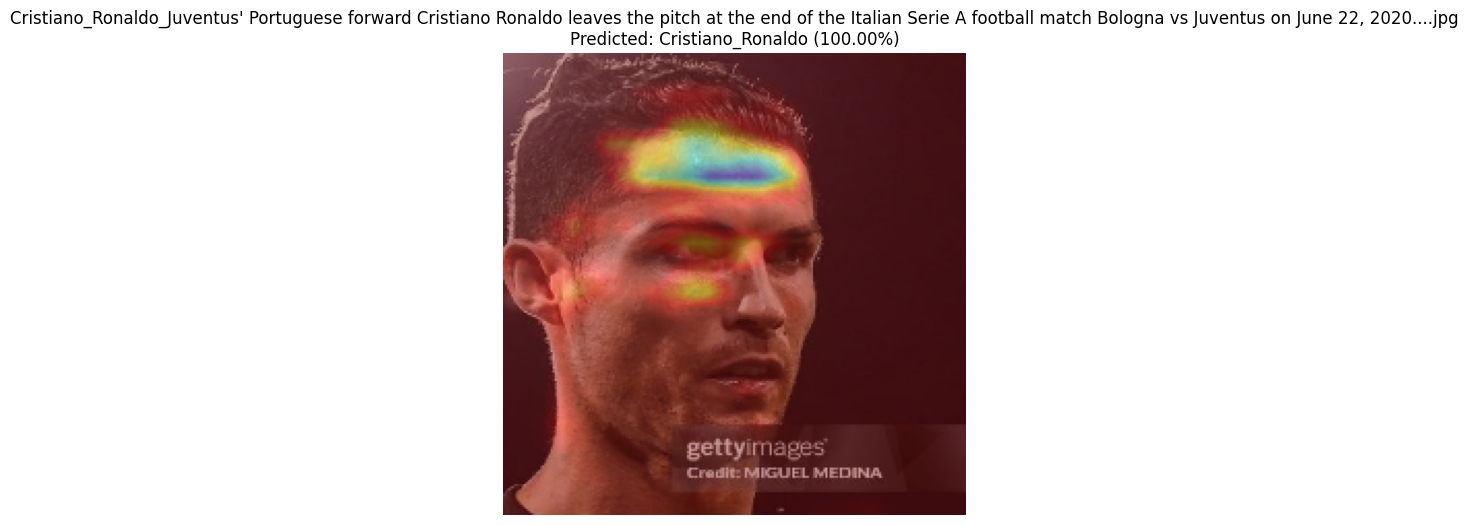

1/1 [==============================] - 0s 53ms/step
Deepika_Padukone_000101.jpg | Deepika_Padukone     | 100.00%


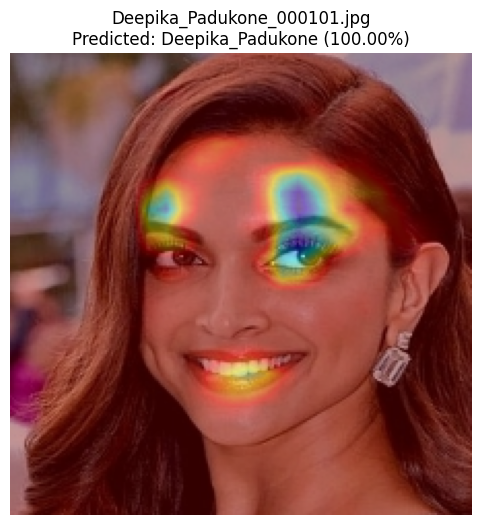

1/1 [==============================] - 0s 19ms/step
download-Copy.jpeg        | Akshay_Kumar         | 100.00%


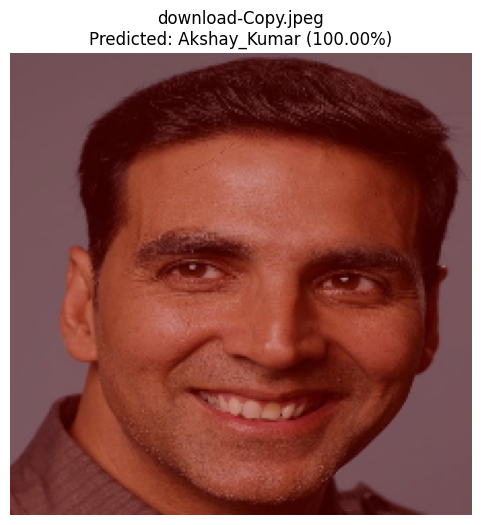

1/1 [==============================] - 0s 66ms/step
download.jpeg             | Akshay_Kumar         |  93.80%


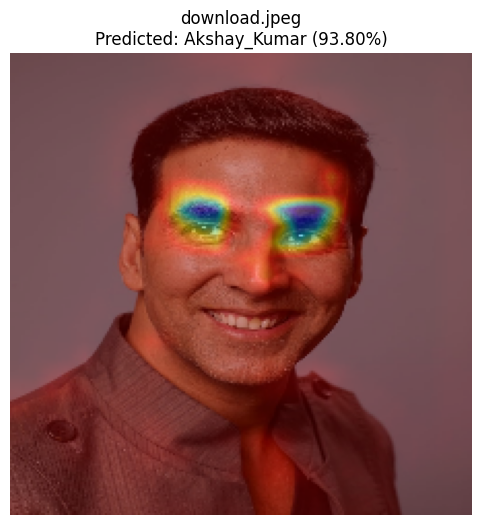

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import json
import os
import sys

# -----------------------------
# 1️⃣ Load Model and Labels
# -----------------------------
model_path = r"D:\Final_Semester_Project\AI_Attendance_System\ai-ml-model\notebooks\face_recognition_attendance_final.h5"
labels_path = r"D:\Final_Semester_Project\AI_Attendance_System\ai-ml-model\notebooks\class_labels.json"

try:
    model = load_model(model_path)
    print("✅ Model loaded successfully.")
except OSError:
    print(f"❌ Cannot find model at {model_path}")
    sys.exit()

try:
    with open(labels_path, "r") as f:
        labels = json.load(f)
except FileNotFoundError:
    print(f"❌ Cannot find class labels at {labels_path}")
    sys.exit()

index_to_name = {v: k for k, v in labels.items()}

# -----------------------------
# 2️⃣ Preprocess Input Image
# -----------------------------
def preprocess_image(image_path, target_size=(224,224)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Cannot read image {image_path}")
        return None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = img_array / 255.0
    return img_array, img_resized

# -----------------------------
# 3️⃣ Generate Grad-CAM
# -----------------------------
def generate_gradcam(model, img_array, class_index, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if "conv" in layer.name:
                last_conv_layer_name = layer.name
                break
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    
    return heatmap.numpy()

# -----------------------------
# 4️⃣ Overlay Heatmap
# -----------------------------
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)
    return overlayed

# -----------------------------
# 5️⃣ Process All Images in Folder
# -----------------------------
folder_path = r"D:\New folder"
supported_extensions = (".jpg", ".jpeg", ".png", ".bmp")

print("\n📋 Predictions:\n" + "-"*50)
print(f"{'Filename':<25} | {'Predicted':<20} | Confidence")
print("-"*50)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(supported_extensions):
        image_path = os.path.join(folder_path, filename)
        img_array, img_resized = preprocess_image(image_path)
        if img_array is None:
            continue
        
        preds = model.predict(img_array)
        class_idx = int(np.argmax(preds[0]))
        predicted_name = index_to_name[class_idx]
        confidence = preds[0][class_idx] * 100  # percentage
        
        # Print neatly
        print(f"{filename:<25} | {predicted_name:<20} | {confidence:6.2f}%")
        
        # Grad-CAM
        heatmap = generate_gradcam(model, img_array, class_idx)
        overlayed_img = overlay_heatmap(img_resized, heatmap)
        
        # Display
        plt.figure(figsize=(6,6))
        plt.imshow(overlayed_img)
        plt.axis('off')
        plt.title(f"{filename}\nPredicted: {predicted_name} ({confidence:.2f}%)")
        plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import sys

# -----------------------------
# 1️⃣ Load Model and Labels
# -----------------------------
model_path = r"D:\Final_Semester_Project\AI_Attendance_System\ai-ml-model\notebooks\face_recognition_attendance_final.h5"
labels_path = r"D:\Final_Semester_Project\AI_Attendance_System\ai-ml-model\notebooks\class_labels.json"

try:
    model = load_model(model_path)
    print("✅ Model loaded successfully.")
except OSError:
    print(f"❌ Cannot find model at {model_path}")
    sys.exit()

try:
    with open(labels_path, "r") as f:
        labels = json.load(f)
except FileNotFoundError:
    print(f"❌ Cannot find class labels at {labels_path}")
    sys.exit()

index_to_name = {v: k for k, v in labels.items()}

# -----------------------------
# 2️⃣ Preprocess Frame
# -----------------------------
def preprocess_frame(frame, target_size=(224,224)):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_array = np.expand_dims(img_resized, axis=0) / 255.0
    return img_array

# -----------------------------
# 3️⃣ Camera Test
# -----------------------------
cap = cv2.VideoCapture("http://192.168.1.14:4747/video")  
if not cap.isOpened():
    print("❌ Cannot access camera.")
    sys.exit()

print("📷 Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame.")
        break

    img_array = preprocess_frame(frame)
    preds = model.predict(img_array, verbose=0)
    class_idx = int(np.argmax(preds[0]))
    confidence = preds[0][class_idx] * 100

    if confidence >= 80:
        predicted_name = index_to_name[class_idx]
        label = f"{predicted_name} ({confidence:.2f}%)"
        color = (0, 255, 0)  # green
    else:
        label = f"Unknown ({confidence:.2f}%)"
        color = (0, 0, 255)  # red

    # Overlay prediction on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2, cv2.LINE_AA)

    cv2.imshow("Camera - Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [ ]:
import mediapipe as mp
